### Image Representation

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(
    root="./data",
    train=True,
    transform=transforms.Compose([transforms.ToTensor()]),
    download=True
)

In [23]:
print(f"{len(mnist_train.data)} | {len(mnist_train.targets)}, {mnist_train[1][0].shape}")

60000 | 60000, torch.Size([1, 28, 28])


torch.Size([28, 28])
(28, 28)


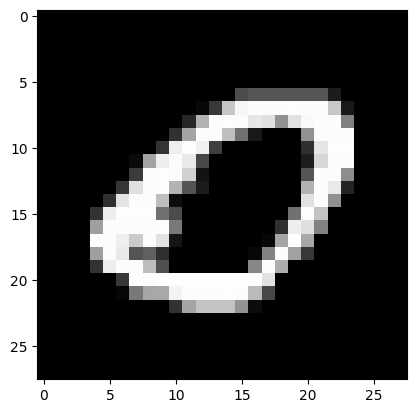

In [37]:
x = mnist_train[1][0].squeeze(0)
print(x.shape)

# transform torch tensor to numpy array
demo_array = np.moveaxis(x.numpy() * int(255), 0, -1)
print(demo_array.shape)

# show image
plt.imshow(demo_array, cmap="gray")
plt.show()

### Audio Representation

In [ ]:
# Download & Unzip datasets
! wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -D urban8k.tgz
! tar -xzf UrbanSound8K.tgz.gz
! rm UrbanSound8K.tar.gz

In [2]:
import os
import time
import librosa
import zipfile
import mutagen
import numpy as np
import pandas as pd
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

In [3]:
!cat ./data/UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

In [30]:
def load_dataset(fn, base_dir:str="./data"):
    df = pd.read_csv(fn)
    filepaths = []
    for _, row in df.iterrows():
        filepaths += [os.path.join(f'{base_dir}/UrbanSound8K/audio', f'fold{row["fold"]}', row["slice_file_name"])]
    df["filepath"] = filepaths
    return df

df = load_dataset('./data/UrbanSound8K/metadata/UrbanSound8K.csv')

In [31]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,./data/UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-117...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-121...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-126...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-137...


In [32]:
df.groupby("class")["slice_file_name"].count()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

In [40]:
# feature extraction using metagen

def compute_audio_stats(df):
    
    def get_audio_metadata(fn):
        f = mutagen.wave.WAVE(fn) # type(f): WAVE
        # f.__dict__.keys() = ['filename', 'info', 'tags']
        return f.info.__dict__
    
    metadata = [get_audio_metadata(filepath) for filepath in df["filepath"]]
    metadata = pd.DataFrame(metadata)    
    df = pd.concat([df, metadata], axis=1)
    return df
        
df = compute_audio_stats(df)

In [43]:
df = df.drop(columns=["fold", "slice_file_name", "fsID", "start", "end", "_number_of_samples"])

We can observe in the following tables that the data has been recorded and digitalized in different ways. 

- It has been mostly recorded using 2 channels in almost all the samples (stereo). 
- The sample rates go from 8kHz to 192kHz (mostly 44kHz, 48Khz)
- The length of the audios goes from 0.0008s to 4s (mostly 4s)
- The bits per sample used go from 4 to 32 (mostly 24 bits)

The data will need to be standardized before to be fed to a machine learning model. 

In [45]:
df.describe()

,salience,classID,audio_format,channels,sample_rate,bits_per_sample,bitrate,length
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8.732000e+03,8732.000000
mean,1.347000,4.592877,20662.098374,1.915369,48456.979272,18.780119,1.800775e+06,3.603644
std,0.476043,2.894544,30450.061443,0.278348,15300.080707,4.227168,9.765852e+05,0.980913
min,1.000000,0.000000,1.000000,1.000000,8000.000000,4.000000,4.409600e+04,0.000816
25%,1.000000,2.000000,1.000000,2.000000,44100.000000,16.000000,1.411200e+06,4.000000
50%,1.000000,4.000000,1.000000,2.000000,44100.000000,16.000000,1.411200e+06,4.000000
75%,2.000000,7.000000,65534.000000,2.000000,48000.000000,24.000000,2.116800e+06,4.000000
max,2.000000,9.000000,65534.000000,2.000000,192000.000000,32.000000,1.228800e+07,4.000000


In [48]:
df.drop(columns=["classID"]).groupby("class").describe()

salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                 audio_format                ...    bitrate              \
                        count          mean  ...        75%         max   
class                                        ...                          
air_conditioner        1000.0  25821.056000  ...  2116800.0   2822400.0   
car_horn                429.0  13138.156177  ...  1536000.0   4608000.0   
children_playing       1000.0  24969.080000  ...  2116800.0   4608000.0   
dog_bark               1000.0  16253.222000  ...  2116800.0   4608000.0   
drilling               1000.0  17170.696000  ...  2116800.0  12288000.0   
engine_idling          1000.0  26148.729000  ...  2304000.0   4608000.0   
gun_shot                374.0  19100.189840  ...  2304000.0   4608000.0   
jackhammer             1000.0  23789.624000  ...  2822400.0   4608000.0   
siren                   929.0  13897.668461  ...  1536000.0   2822400.0   
street_music           1000.0  20578.362000  ...  2116800.0   4608000.0   

                  length                                                    \
                   count      mean       std       min       25%       50%   
class                                                                        
air_conditioner   1000.0  3.994928  0.093128  2.040000  4.000000  4.000000   
car_horn           429.0  2.456123  1.618848  0.050000  0.738292  3.490000   
children_playing  1000.0  3.933895  0.424658  0.008073  4.000000  4.000000   
dog_bark          1000.0  3.148281  1.331572  0.119819  2.040000  4.000000   
drilling          1000.0  3.542295  1.013475  0.007937  4.000000  4.000000   
engine_idling     1000.0  3.935952  0.370909  0.766553  4.000000  4.000000   
gun_shot           374.0  1.647699  0.902516  0.166281  1.009195  1.472698   
jackhammer        1000.0  3.609071  0.891129  0.000816  4.000000  4.000000   
siren              929.0  3.910314  0.502674  0.260000  4.000000  4.000000   
street_music      1000.0  4.000000  0.000000  4.000000  4.000000  4.000000   

                                 
                       75%  max  
class                            
air_conditioner   4.000000  4.0  
car_horn          4.000000  4.0  
children_playing  4.000000  4.0  
dog_bark          4.000000  4.0  
drilling          4.000000  4.0  
engine_idling     4.000000  4.0  
gun_shot          2.185255  4.0  
jackhammer        4.000000  4.0  
siren             4.000000  4.0  
street_music      4.000000  4.0  

[10 rows x 56 columns]

Number of classes: 10


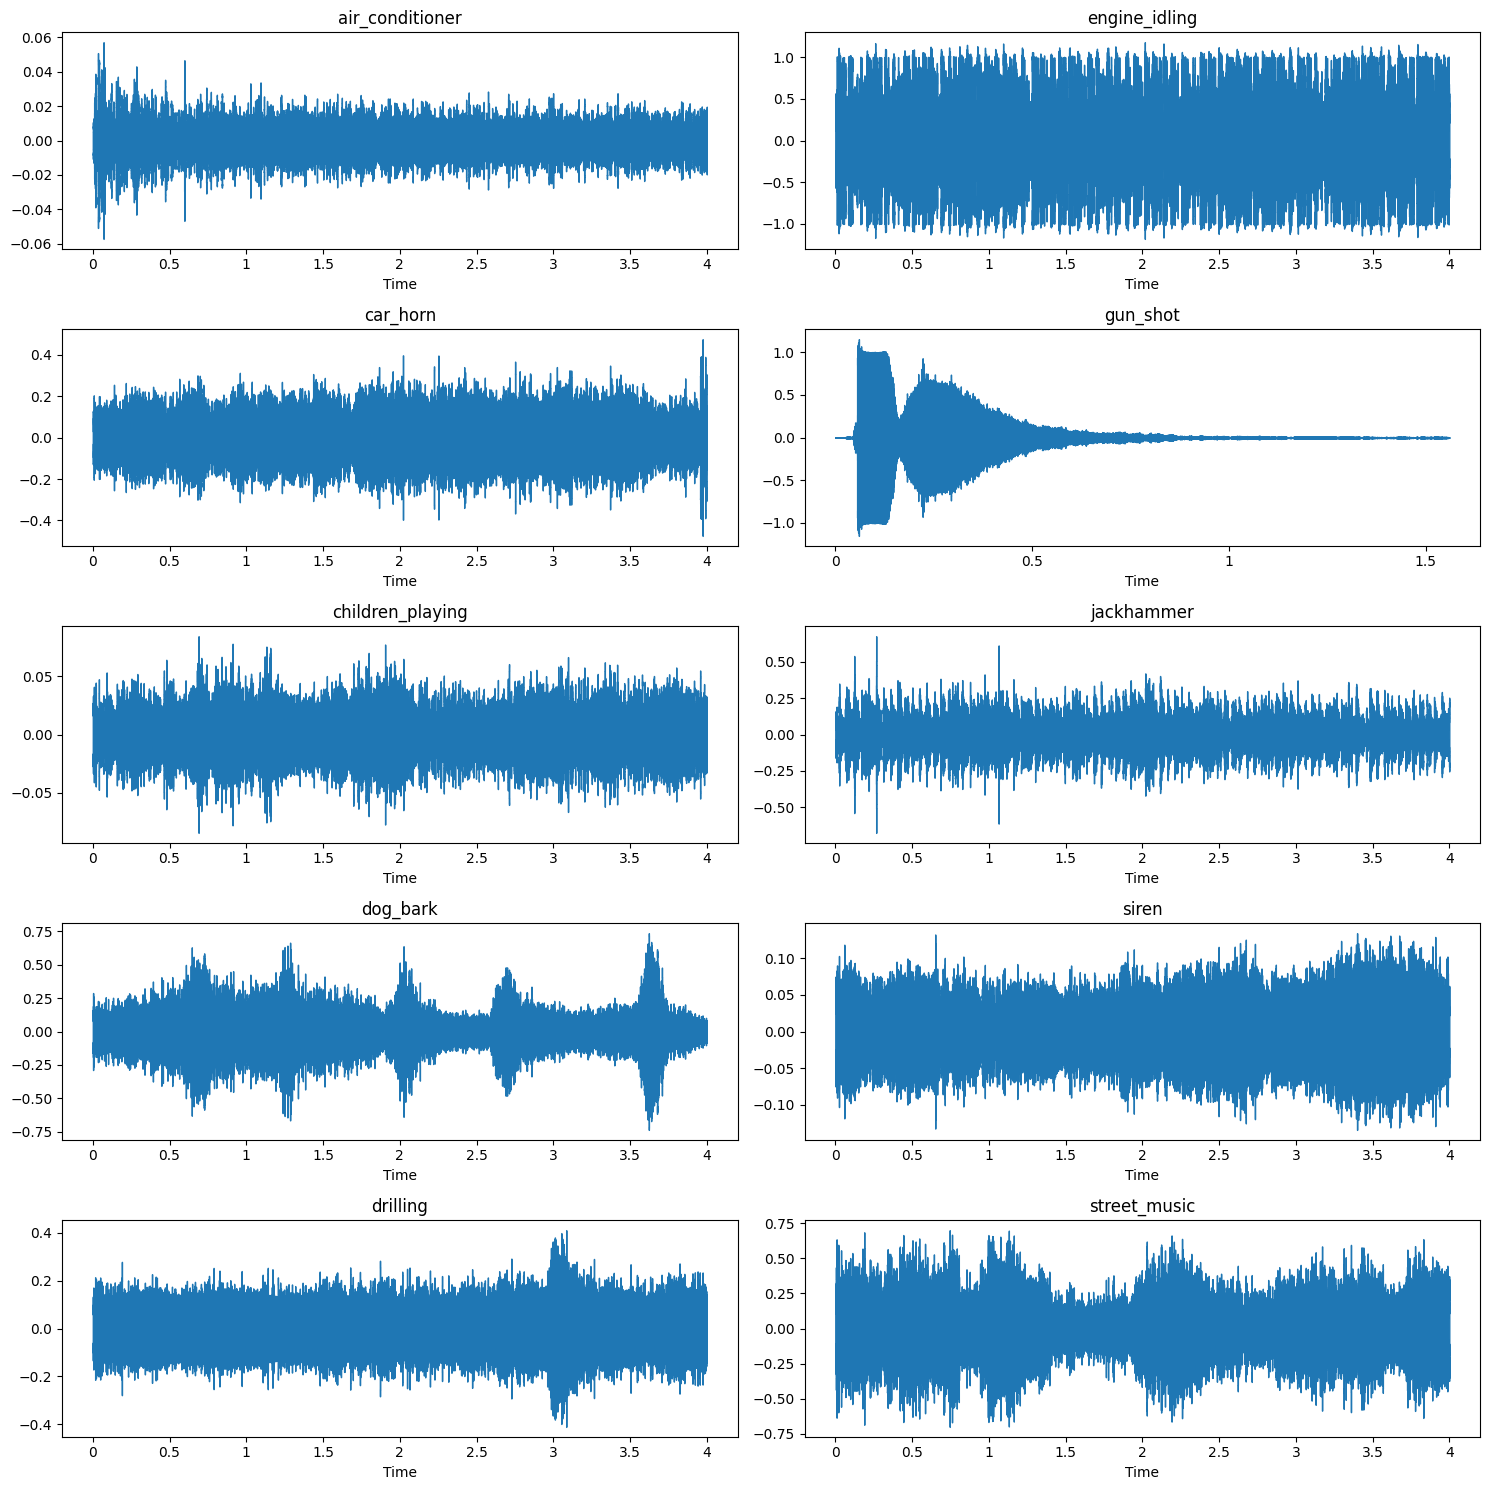

In [72]:
# random samples by each class

random_samples = df.groupby("class").sample(1)
fns, labels = random_samples["filepath"].tolist(), random_samples["class"].tolist()

print(f"Number of classes: {len(df['class'].unique())}")

# visualize the waveforms
n_rows, n_cols = 5, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))

i = 0
for col in range(n_cols):
    for row in range(n_rows):
        file, sample_rate = librosa.load(fns[i]) # file: ndarray
        librosa.display.waveshow(file, sr=sample_rate, ax=axs[row][col])
        axs[row][col].set_title(f'{labels[i]}')
        i += 1
fig.tight_layout()

STFT (Short-Term Fourier Transform), Mel-Spectograms and MFCC (Mel-Frequency Cepstral Coefficients) are all popular ways to process audio signals and generate features as input for machine learning algorithms such as Convolutional Neural Networks. 
- STFT and Mel-Spectograms are very similar (at least in the shape perspective as the results).
- STFT and MFCC are the most popular ones being used.

In [ ]:
# STFT (Log Y Axis)

# visualize the STFT
n_fft = 2048
hop_length = n_fft // 4

n_rows, n_cols = 5, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
i = 0

for col in range(n_cols):
    for row in range(n_rows):
        file, sample_rate = librosa.load(fns[i]) # file: ndarray
        stft = librosa.stft(file, n_fft=n_fft, hop_length=hop_length)
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(
            S_db,
            sr=n_fft,
            hop_length=hop_length,
            x_axis="time",
            y_axis="log",
            ax=axs[row][col]
        )
        axs[row][col].set_title(f'{labels[i]}')
        i += 1
        
fig.tight_layout()

In [ ]:
# Mel-Spectogram

# the Mel-Spectogram which is a representation of the different frequencies magnitudes at different timesteps. The frequency magnitude is transformed to be on the Mel Scale, that takes into account how humans perceive and process audio signals.

# visualize the Mel-Spectogram
n_fft = 2048
hop_length = n_fft // 4

n_rows, n_cols = 5, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
i = 0

for col in range(n_cols):
    for row in range(n_rows):
        file, sample_rate = librosa.load(fns[i]) # file: ndarray
        stft = librosa.stft(file, n_fft=n_fft, hop_length=hop_length)
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(
            S_db,
            sr=n_fft,
            hop_length=hop_length,
            x_axis="time",
            y_axis="mel",
            ax=axs[row][col]
        )
        axs[row][col].set_title(f'{labels[i]}')
        i += 1
        
fig.tight_layout()

In [ ]:
# MFCC

# visualize the 40 MFCCs
n_fft = 2048
hop_length = n_fft // 4

n_rows, n_cols = 5, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
i = 0

for col in range(n_cols):
    for row in range(n_rows):
        file, sample_rate = librosa.load(fns[i]) # file: ndarray
        mfccs = librosa.feature.mfcc(y=file, sr=sample_rate, n_fft=n_fft, n_mfcc=40)
        librosa.display.specshow(
            mfccs,
            sr=n_fft,
            hop_length=hop_length,
            x_axis="time",
            ax=axs[row][col]
        )
        axs[row][col].set_title(f'{labels[i]}')
        i += 1
fig.tight_layout()

In [82]:
# Way to convert audio file to vectors (input to the machine learning model)

audio_file, sample_rate = librosa.load(fns[0])

# compute the stft
stft = librosa.stft(audio_file)  # STFT of y

S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
print(S_db.shape)

(1025, 173)


In [89]:
# Way to convert audio file to vectors (input to the machine learning model)

audio_file, sample_rate = librosa.load(fns[0])

# compute the stft
stft = librosa.stft(audio_file)  # STFT of y
print(stft.shape)

# convert the stft to a matrix
matrix = np.abs(stft)
print(matrix.shape)

# convert the stft to a vector
vector = matrix.reshape(-1)
print(vector.shape)

# convert the stft to a tensor
tensor = matrix[np.newaxis, :, :]
print(tensor.shape)

(1025, 173)
(1025, 173)
(177325,)
(1, 1025, 173)
